In [1]:
import numpy as np;from scipy import signal;from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter, iirdesign, zpk2tf, freqz
import h5py;import json
import matplotlib.pyplot as plt;import matplotlib.mlab as mlab 
import readligo as rl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load LIGO data.

In [2]:
eventname = 'GW150914' 
eventname = 'GW151226' 
eventname = 'LVT151012'
#eventname = 'GW170104'
plottype = "png"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")

In [3]:
# both H1 and L1 will have the same time vector, so:
time = time_H1-time_H1[0]

# Save the data start time in seconds since Jan 6, 1980 GMT
data_start_std = time_H1[0]

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

## Raw Data

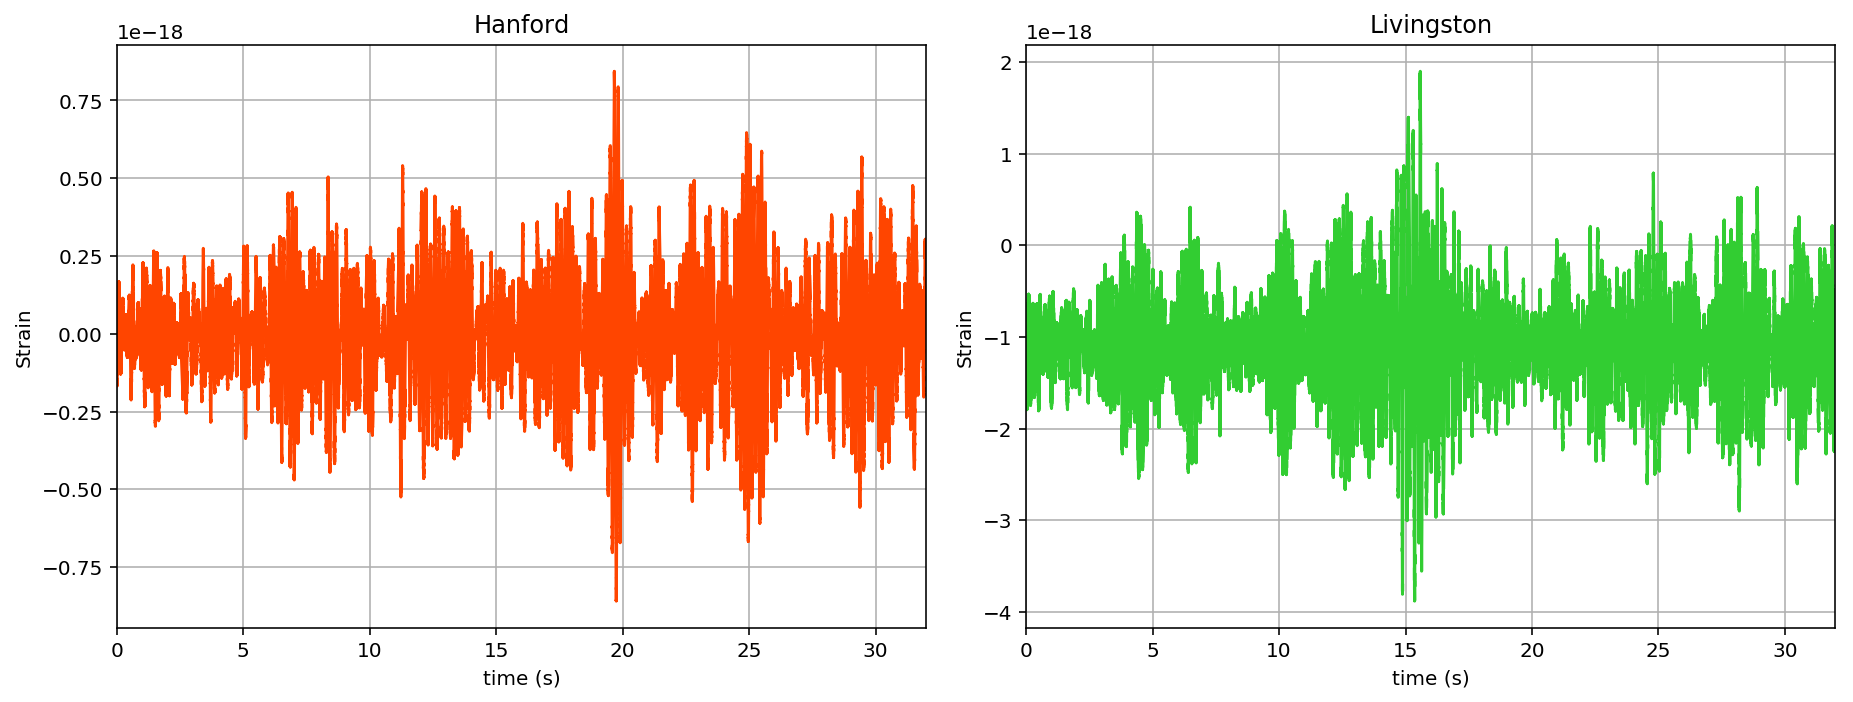

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))

ax[0].plot(time,strain_H1,color = 'orangered',label='H1 strain')
ax[0].set_title("Hanford");ax[0].set_xlabel('time (s)');ax[0].set_ylabel("Strain")
ax[0].grid();ax[0].set_xlim([0,32])

ax[1].plot(time,strain_L1,color='limegreen',label='L1 strain')
ax[1].set_title("Livingston");ax[1].set_xlabel('time (s)');ax[1].set_ylabel("Strain")
ax[1].grid();ax[1].set_xlim([0,32])

plt.tight_layout()
plt.show()

# Load Template

In [5]:
# Read in the template (plus and cross polarizations of the wave)
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    
template_p, template_c = f_template["template"][...]
t_approx = f_template["/meta"].attrs['approx']
f_template.close()

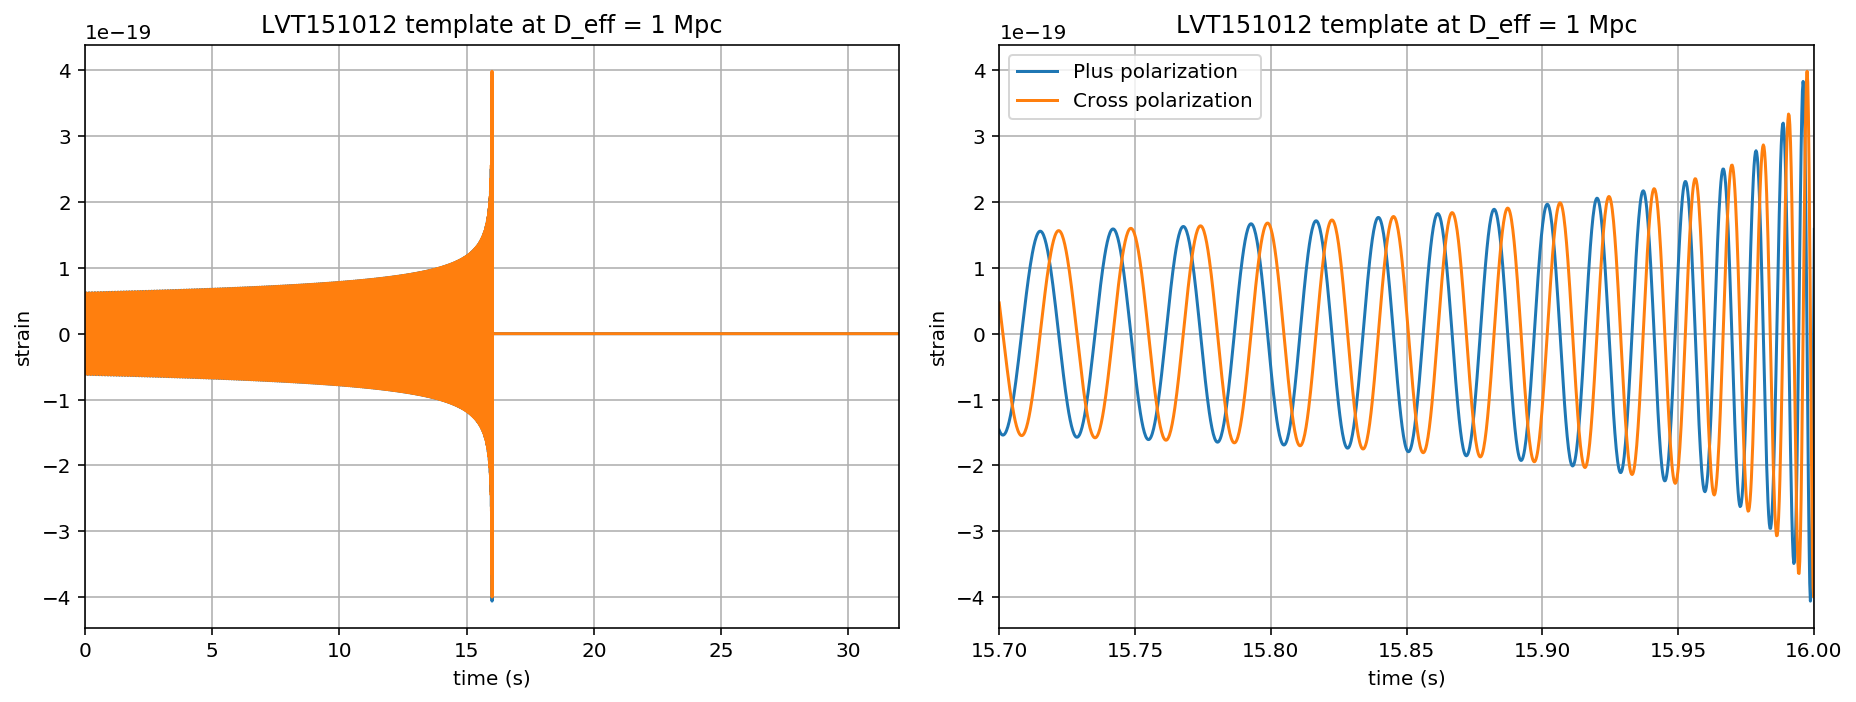

In [6]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))

ax[0].plot(time-time[0],template_p)
ax[0].plot(time-time[0],template_c)
ax[0].set_xlim([0,32]);ax[0].grid()
ax[0].set_xlabel('time (s)');ax[0].set_ylabel('strain');ax[0].set_title(eventname+' template at D_eff = 1 Mpc')

ax[1].plot(time-time[0],template_p,label = "Plus polarization")
ax[1].plot(time-time[0],template_c,label = "Cross polarization")
ax[1].set_xlim([15.7,16]);ax[1].grid();plt.legend()
ax[1].set_xlabel('time (s)');ax[1].set_ylabel('strain');ax[1].set_title(eventname+' template at D_eff = 1 Mpc')

plt.tight_layout()

## Power spectral density function

In [7]:
NFFT = 4*fs
PSD_WINDOW = np.hanning(NFFT)
NOVL = 0

def PSD(S):
    return signal.welch(S, fs = fs, nfft = NFFT, window=PSD_WINDOW, noverlap=NOVL)

In [8]:
freqs,PSD_H1 = PSD(strain_H1)
freqs,PSD_L1 = PSD(strain_L1)

# Power spectral density interpolation function (for calculating the PSD at frequencies not
# returned by Welch's method)
H_psd = interp1d(freqs, PSD_H1)
L_psd = interp1d(freqs, PSD_L1)

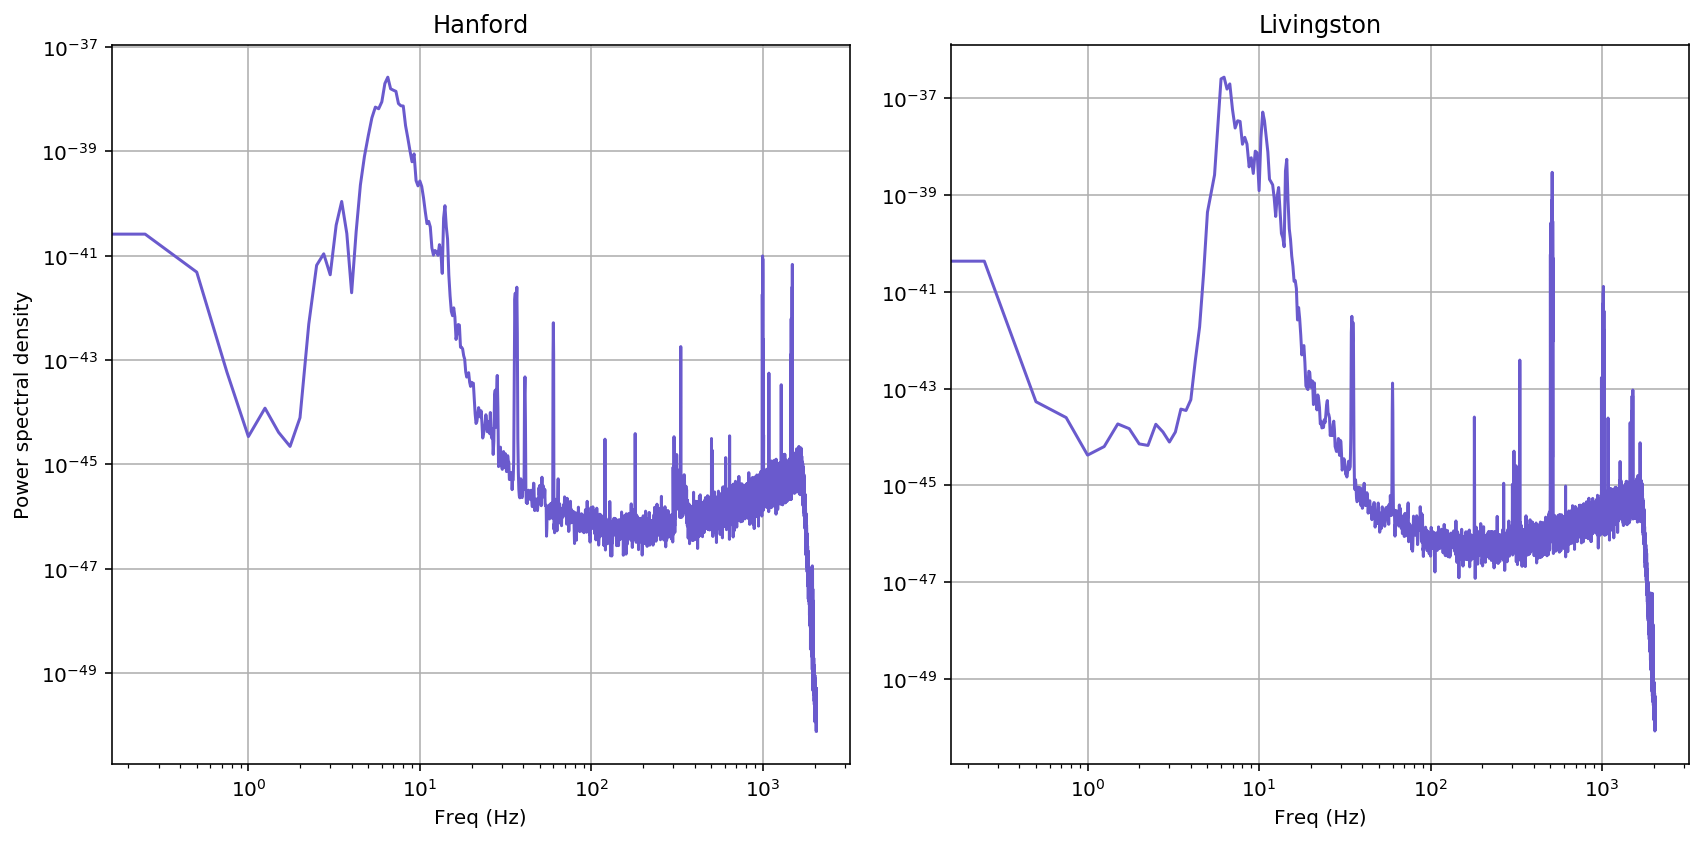

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(12,6))

ax[0].loglog(freqs,PSD_H1,color = "slateblue")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].set_ylabel("Power spectral density")
ax[0].grid()

ax[1].loglog(freqs,PSD_L1,color='slateblue')
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)')
ax[1].grid()

plt.tight_layout()
plt.show()

## Data whitening

In [10]:
l = strain_H1.size
freqs = np.fft.rfftfreq(l, dt)

# customizable cosine window
window = signal.tukey(l, alpha=1./2)

# Fourier transform of windowed data
H_ft = np.fft.rfft(strain_H1*window)
L_ft = np.fft.rfft(strain_L1*window)

# Get the Whitened data and go back to the time domain!
H_wh = np.fft.irfft(H_ft / np.sqrt(H_psd(freqs)) * (1./np.sqrt(1./(dt*2))), n=l)
L_wh = np.fft.irfft(L_ft / np.sqrt(L_psd(freqs)) * (1./np.sqrt(1./(dt*2))), n=l)

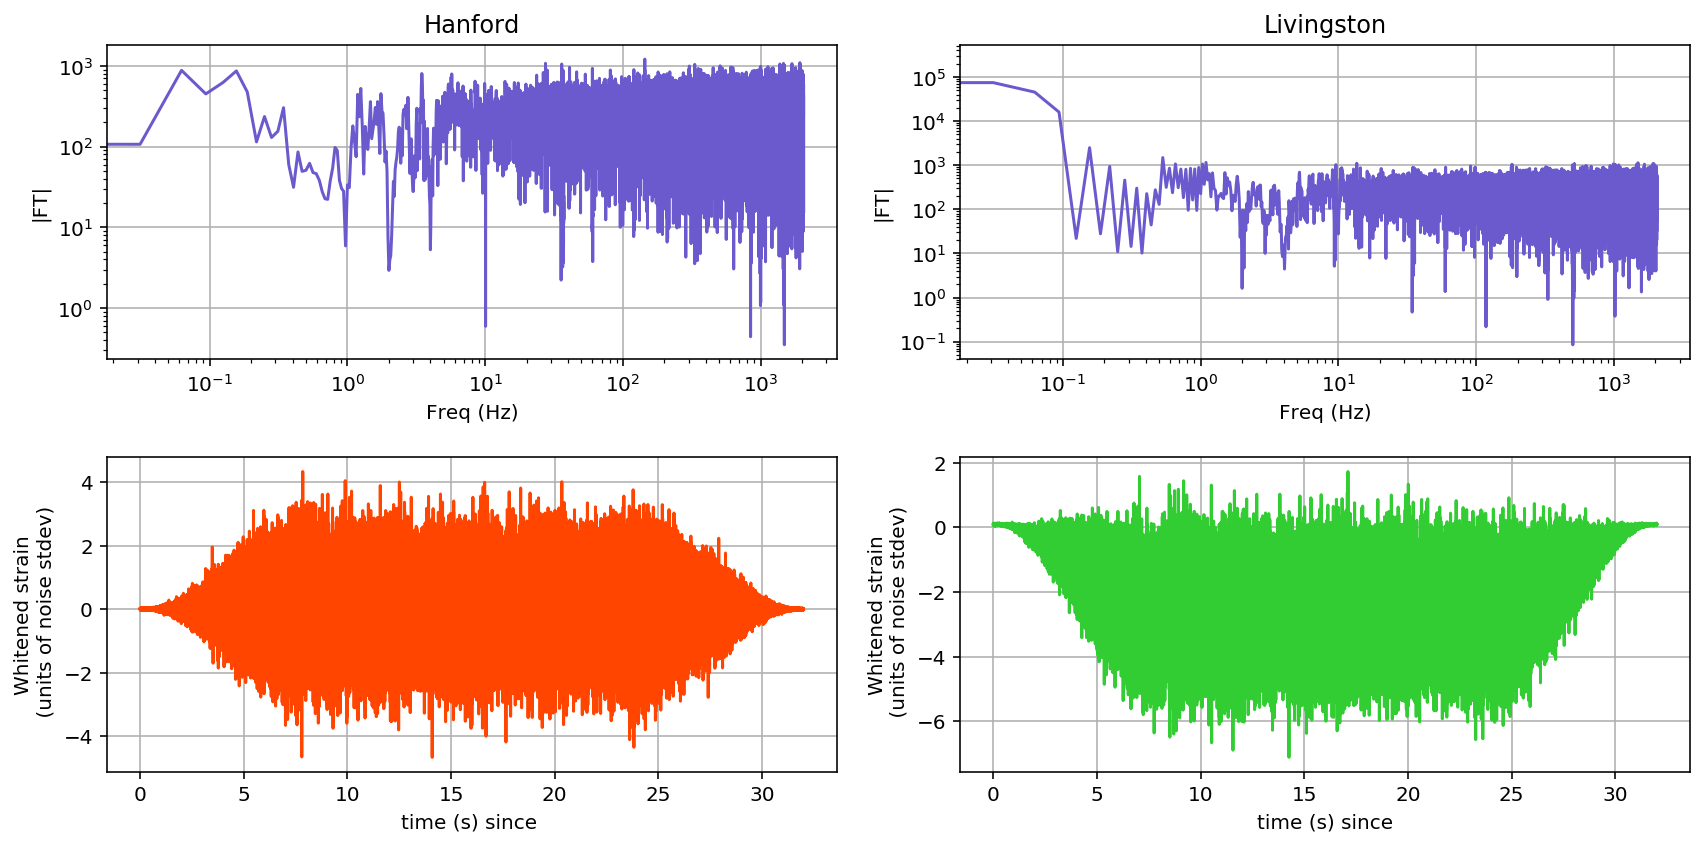

In [11]:
fig, ax = plt.subplots(2, 2,figsize=(12,6))

ax[0,0].loglog(freqs,np.abs(np.fft.rfft(H_wh,n=l)),color = "slateblue")
ax[0,0].set_title("Hanford");ax[0,0].set_xlabel('Freq (Hz)');ax[0,0].set_ylabel("|FT|")
ax[0,0].grid();ax[0,0].set_xlim(None)

ax[0,1].loglog(freqs,np.abs(np.fft.rfft(L_wh,n=l)),color = "slateblue")
ax[0,1].set_title("Livingston");ax[0,1].set_xlabel('Freq (Hz)');ax[0,1].set_ylabel("|FT|")
ax[0,1].grid();ax[0,1].set_xlim(None)

ax[1,0].plot(time,H_wh,color='orangered')
ax[1,0].set_xlabel('time (s) since ');ax[1,0].set_ylabel("Whitened strain\n (units of noise stdev)")
ax[1,0].grid();ax[0,0].set_xlim(None)

ax[1,1].plot(time,L_wh,color='limegreen')
ax[1,1].set_xlabel('time (s) since');ax[1,1].set_ylabel("Whitened strain\n (units of noise stdev)")
ax[1,1].grid();ax[1,1].set_xlim(None)

plt.tight_layout()
plt.show()

## Bandpass Filter:

Now the signal is not quite yet visible because of low and high frequency noise in regions far outside that of interest.

$\rightarrow$ Apply a Bandpass filter to the remaining signal

In [12]:
print("Region of interest in the frequency domain : ",fband[0],"-",fband[1]," Hz ")

Region of interest in the frequency domain :  43.0 - 400.0  Hz 


In [13]:
# Bandpass function (more or less the same as used by LIGO tutorial)
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(data, frequencies, fs, order=6):
    lowcut,highcut = frequencies
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [14]:
H_wh_bp = bandpass_filter(H_wh,fband,fs)
L_wh_bp = bandpass_filter(L_wh,fband,fs)

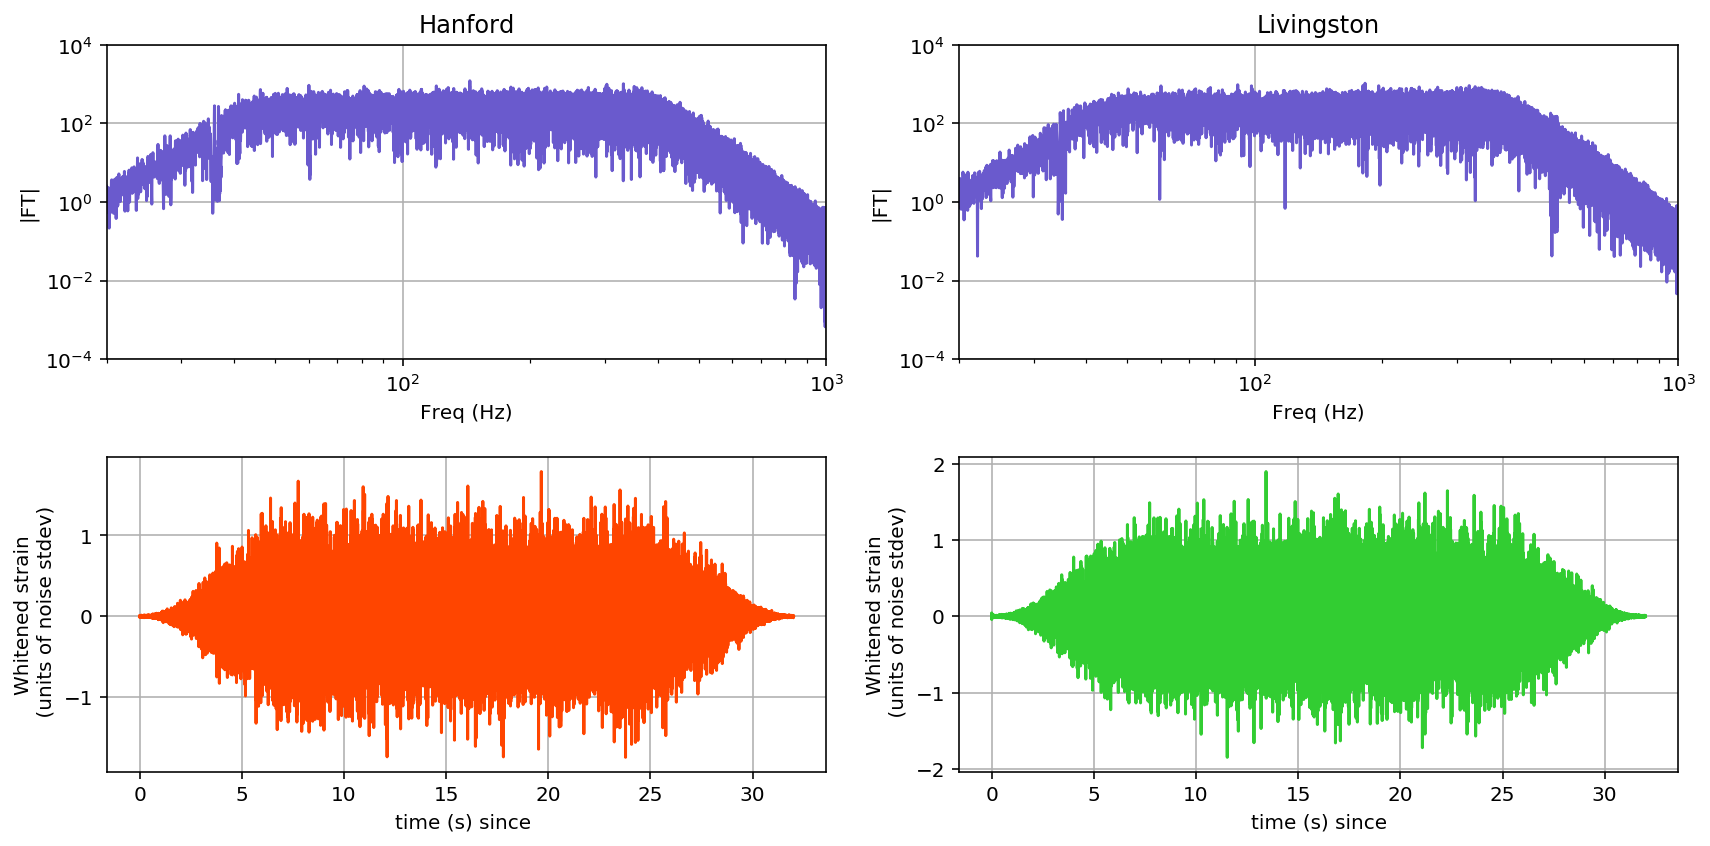

In [15]:
fig, ax = plt.subplots(2, 2,figsize=(12,6))

ax[0,0].loglog(freqs,np.abs(np.fft.rfft(H_wh_bp,n=l)),color = "slateblue")
ax[0,0].set_title("Hanford");ax[0,0].set_xlabel('Freq (Hz)');ax[0,0].set_ylabel("|FT|")
ax[0,0].grid();ax[0,0].set_xlim([20,1000]);ax[0,0].set_ylim([1e-4,1e4])

ax[0,1].loglog(freqs,np.abs(np.fft.rfft(L_wh_bp,n=l)),color = "slateblue")
ax[0,1].set_title("Livingston");ax[0,1].set_xlabel('Freq (Hz)');ax[0,1].set_ylabel("|FT|")
ax[0,1].grid();ax[0,1].set_xlim([20,1000]);ax[0,1].set_ylim([1e-4,1e4])

ax[1,0].plot(time,H_wh_bp,color='orangered')
ax[1,0].set_xlabel('time (s) since ');ax[1,0].set_ylabel("Whitened strain\n (units of noise stdev)")
ax[1,0].grid();ax[0,0].set_xlim(None)

ax[1,1].plot(time,L_wh_bp,color='limegreen')
ax[1,1].set_xlabel('time (s) since');ax[1,1].set_ylabel("Whitened strain\n (units of noise stdev)")
ax[1,1].grid();ax[1,1].set_xlim(None)

plt.tight_layout()
plt.show()

$\bullet$ As we can see, the filter has sigificantly suppressed the frequency content outside the main region of interest.

In [16]:
# Template preparation
template = (template_p + template_c*1.j) 
# Plus and cross polarizations of the wave encoded as real and imaginary parts of template.
# This seemed to be a mistake in the code "simple_read_ligo.py" where the 

temp_freq = np.fft.fftfreq(template.size)*fs

# Take the full complex Fourier Transform (FFT) of the template and strain data (with windowing)
temp_ft = np.fft.fft(template*window)*dt
H_ft = np.fft.fft(strain_H1*window)*dt
L_ft = np.fft.fft(strain_L1*window)*dt

In [17]:
df = np.abs(temp_freq[1] - temp_freq[0])

In [18]:
# Get the Power Spectral Density values at the needed frequencies
H_Sn = np.interp(np.abs(temp_freq), freqs, H_psd(freqs))
L_Sn = np.interp(np.abs(temp_freq), freqs, L_psd(freqs))

# Matched filter implimentation

We pass our whitened signal $s_w(t)$ through a filter with with impulse response $h(t)$, the output is:
\begin{equation}
    y(\tau) = \int_{-\infty}^{\infty} s_w(\tau-t) h(t) dt
\end{equation}

We have a template which represents the ideal gravitational wave signal, and we want to find where in the signal the template waveform lies (if it even does!).  

If we chose $h(t)$ to equal our template waveform, the filter will have the hightest possible signal to noise ratio when the data follows the template. This gives us the best way of finding a known signal buried in noise.

The matched filter calculation is a convolution, which can be simplified using the fourier transform. The matched filter can ultimately be expressed as:
\begin{equation}
    m(t) = 2\int_{-\infty}^{\infty} \frac{\tilde{s}(f)\tilde{h}(f)^*}{S_n(f)}e^{2\pi ift} df
\end{equation}

Where $\tilde{s}(f)$ and $\tilde{h}(f)$ are the fourier transforms of the signal and template waveforms, respectively, and $S_n(f)$ is the spectral power density of the signal.

In [19]:
internal = (H_ft * temp_ft.conjugate()) / H_Sn
H_m = 2*np.fft.ifft(internal)*fs

internal = (L_ft * temp_ft.conjugate()) / L_Sn
L_m = 2*np.fft.ifft(internal)*fs

Since the noise is stationary, the noise variance is given by:
\begin{equation}
    \sigma_m^2 = \int_{-\infty}^{\infty} \frac{|\tilde{h}(f)|^2}{S_n(f)} df
\end{equation}

In [20]:
variance = (temp_ft * temp_ft.conjugate() / H_Sn).sum() * df
H_sigma = np.sqrt(np.abs(variance))

variance = (temp_ft * temp_ft.conjugate() / L_Sn).sum() * df
L_sigma = np.sqrt(np.abs(variance))

The amplitude signal to noise ratio is defined as:
\begin{equation}
\rho(t) = \frac{|m(t)|}{\sigma_m}
\end{equation}

In [21]:
H_m_signal = H_m/H_sigma
H_SNR = np.abs(H_m_signal)

L_m_signal = L_m/L_sigma
L_SNR = np.abs(L_m_signal)

# SNR analysis
$\rightarrow$  The SNR will be strongly peaked at the time when the shifted data and template agree.

In [22]:
# Find the array index of the peak
H_index = np.where(H_SNR == max(H_SNR))[0][0]
L_index = np.where(L_SNR == max(L_SNR))[0][0]

## Finding the time offset
$\rightarrow$ Using the index position of the max SNR, we can determine the time offset between each of the data sets from the template!

In [23]:
H_t = time[H_index]
L_t = time[L_index]

t_offset = H_t-L_t

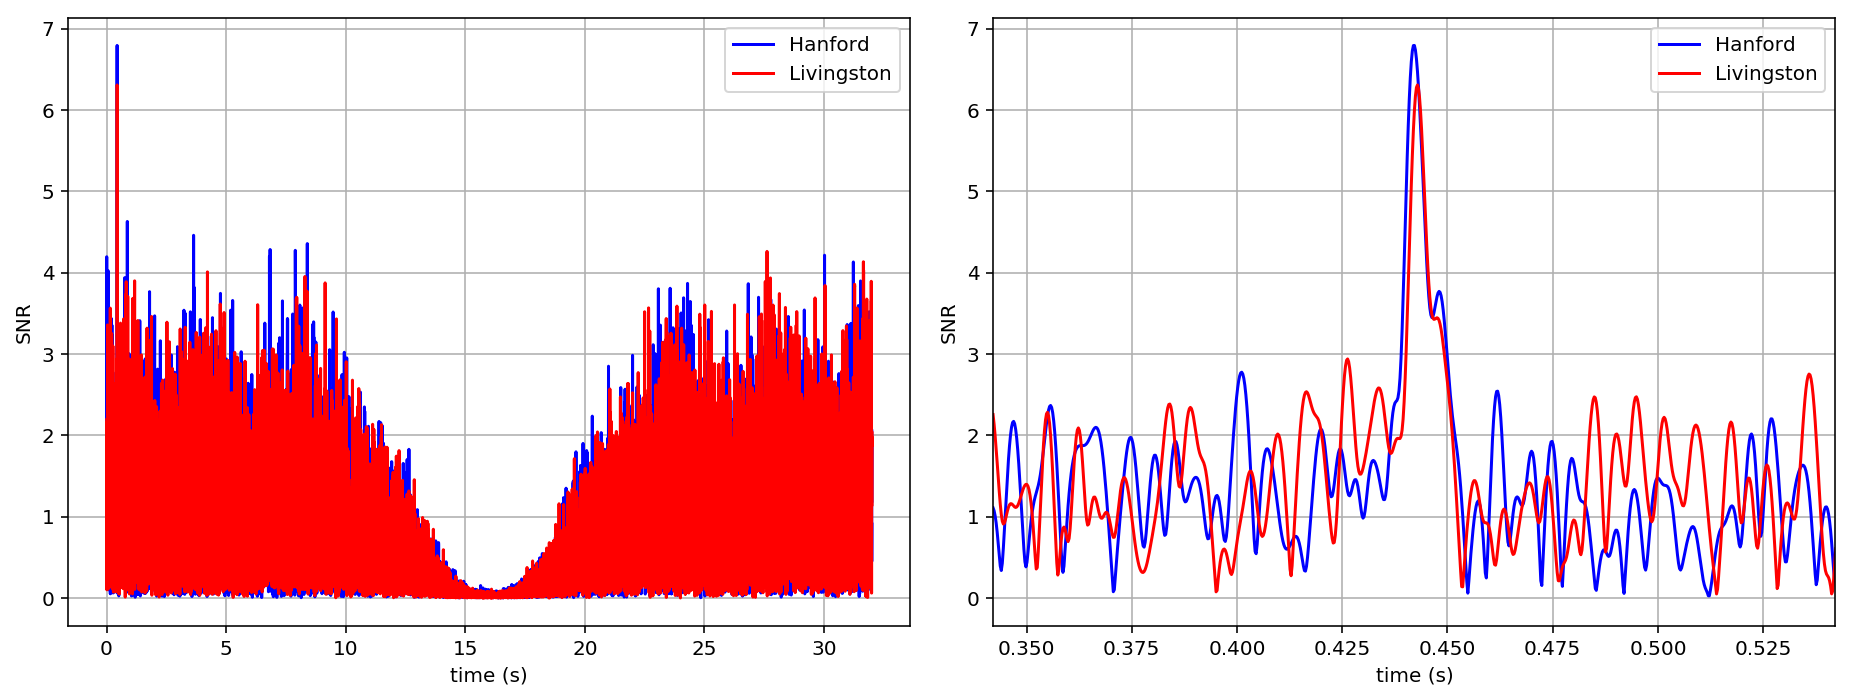

In [24]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))

ax[0].plot(time,H_SNR,color = "blue",label = "Hanford")
ax[0].plot(time,L_SNR,color = "red",label = "Livingston")
ax[0].set_xlabel('time (s)');ax[0].set_ylabel("SNR")
ax[0].grid();ax[0].set_xlim(None);ax[0].legend()

ax[1].plot(time,H_SNR,color = "blue",label = "Hanford")
ax[1].plot(time,L_SNR,color = "red",label = "Livingston")
ax[1].set_xlabel('time (s)');ax[1].set_ylabel("SNR")
ax[1].grid();ax[1].set_xlim([H_t-0.1,H_t+0.1]);ax[1].legend()

plt.tight_layout()
plt.show()

## Template phasing
$\rightarrow$ Combine the plus and cross polarizations with appropriate phasing

In [25]:
phase = np.angle(H_m_signal[H_index])
H_template_phaseshifted = np.real(template*np.exp(1j*phase))   

phase = np.angle(L_m_signal[L_index])
L_template_phaseshifted = np.real(template*np.exp(1j*phase))   

## Whiten and Filter the template

In [26]:
H_d_eff = H_sigma / H_SNR[H_index]
L_d_eff = L_sigma / L_SNR[L_index]

In [27]:
template_phaseshifted_ft = np.fft.rfft(H_template_phaseshifted/H_d_eff*window)
datafreq = np.fft.rfftfreq(H_template_phaseshifted.size,d=dt)
S_n = np.interp(datafreq, freqs, H_psd(freqs))
H_temp_wh = np.fft.irfft(template_phaseshifted_ft/np.sqrt(S_n)* (1./np.sqrt(1./(dt*2))))


template_phaseshifted_ft = np.fft.rfft(L_template_phaseshifted/L_d_eff*window)
datafreq = np.fft.rfftfreq(L_template_phaseshifted.size,d=dt)
S_n = np.interp(datafreq, freqs, L_psd(freqs))
L_temp_wh = np.fft.irfft(template_phaseshifted_ft/np.sqrt(S_n)* (1./np.sqrt(1./(dt*2))))

H_temp_wh_bp = bandpass_filter(H_temp_wh,fband,fs)
L_temp_wh_bp = bandpass_filter(L_temp_wh,fband,fs)

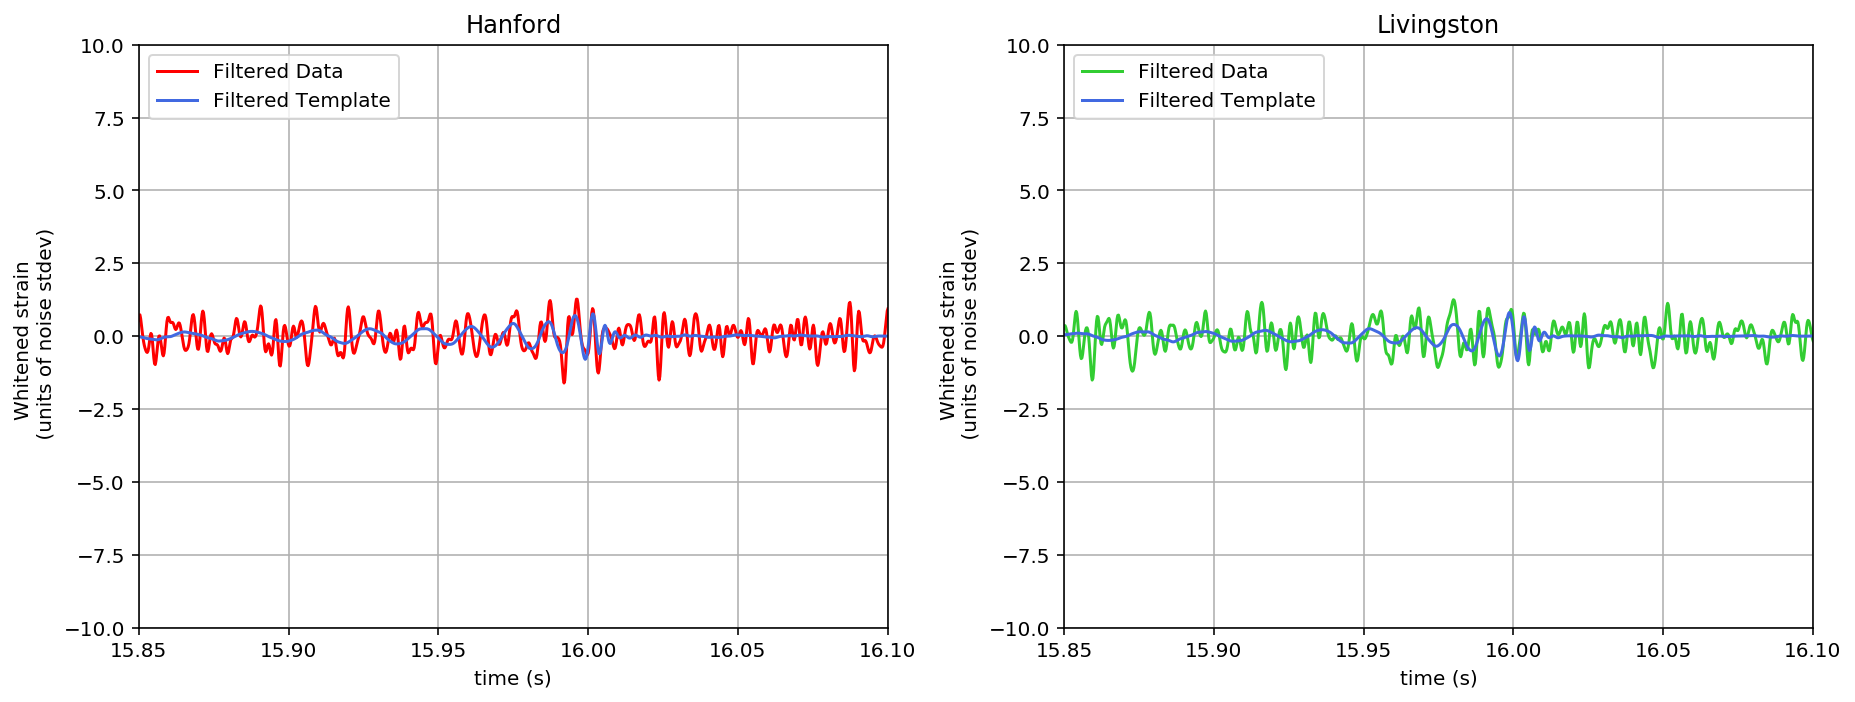

In [32]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))
gr = 16.
ax[0].plot(time-H_t,H_wh_bp,color='r',label = "Filtered Data")
ax[0].plot(time,H_temp_wh_bp,color='royalblue',label = "Filtered Template")
ax[0].set_title("Hanford");ax[0].set_xlabel('time (s)');ax[0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0].grid();ax[0].set_xlim([16-0.15,16+0.1]);ax[0].legend(loc=2);ax[0].set_ylim([-10,10])


ax[1].plot(time-L_t,L_wh_bp,color='limegreen',label = "Filtered Data")
ax[1].plot(time,L_temp_wh_bp,color='royalblue',label = "Filtered Template")
ax[1].set_title("Livingston");ax[1].set_xlabel('time (s)');ax[1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1].grid();ax[1].set_xlim([16-0.15,16+0.1]);ax[1].legend(loc=2);ax[1].set_ylim([-10,10])
#[gr-0.15,gr+0.03]
plt.tight_layout()
plt.show()